# A training example in Pytorch
## Introduction
### Task
In this notebook we will train a neural network to do a simple task. This will be a classification task : as explained in the first week of lectures, classification basically means to find a *decision boundary* over a space of real numbers. For representation purposes we will work with a 2D example : the decision boundary will be a circle. More precisely, it will be the unity circle in the plane.
![](unitycircle.png)
### Sampling
We will generate points $(x_1,x_2)$ to classify, and their class $y$. The actual decision fonction is $y=1_{x_1^2+x_2^2<1}$.

To have a balanced dataset with about as many points in each class, we will sample uniformly over polar coordinates,  within the circle of center 0 and radius 2.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def sample_points(n):
    # returns (X,Y), where X of shape (n,2) is the numpy array of points and Y is the (n) array of classes
    
    radius = np.random.uniform(low=0,high=2,size=n).reshape(-1,1) # uniform radius between 0 and 2
    angle = np.random.uniform(low=0,high=2*np.pi,size=n).reshape(-1,1) # uniform angle
    x1 = radius*np.cos(angle)
    x2=radius*np.sin(angle)
    y = (radius<1).astype(int).reshape(-1)
    x = np.concatenate([x1,x2],axis=1)
    return x,y

In [ ]:
# Generate the data
trainx,trainy = sample_points(10000)
valx,valy = sample_points(500)
testx,testy = sample_points(500)

print(trainx.shape,trainy.shape)

(10000, 2) (10000,)


Our model will be a multi-layer perceptron with one hidden layer, and an output of size 2 since we have two classes. Since it is a binary classification task we could also use just one output and a zero threshold, but we will use two to illustrate the use of the pytorch Cross-Entropy loss (next week you will see how to use BinaryCrossEntropy for such a task).

As you know from the lectures, such a model cannot represent a circular boundary but could represent a polygonal boundary, whose number of sides is the number of neurons on the hidden layer. For example, with 6 hidden neurons the model could compute a hexagonal boundary that approximate the unity circle, such as :
![](hexagon.png)

Note that the optimal accuracy to expect from an hexagone approximating the unity circle is of about **xxxx**. Of course the trained model won't compute an actual hexagone, due to the activation that isn't a threshold, and the liberty of the final layer's weights (it does not have to be an AND). We can actually expect *better* accuracy than this.

In [ ]:
def generate_single_hidden_MLP(n_hidden_neurons):
    return nn.Sequential(nn.Linear(2,n_hidden_neurons),nn.ReLU(),nn.Linear(n_hidden_neurons,2))
model1 = generate_single_hidden_MLP(6)

To train our model, we will need to feed it with tensors. Let's transform our generated numpy arrays :

In [ ]:
trainx = torch.from_numpy(trainx).float()
valx = torch.from_numpy(valx).float()
testx = torch.from_numpy(testx).float()
trainy = torch.from_numpy(trainy)
valy = torch.from_numpy(valy)
testy = torch.from_numpy(testy)
print(trainx.type(),trainy.type())

torch.FloatTensor torch.LongTensor


Now we will define our training routine. There is the question of whether to perform our traing on CPU or GPU. The best thing to do is to use a flag variable that you will set, when you actually do the training.

In [ ]:
def training_routine(net,dataset,n_iters,gpu):
    # organize the data
    train_data,train_labels,val_data,val_labels = dataset
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(),lr=0.01)
    
    # use the flag
    train_data,train_labels = train_data,train_labels.long()
    val_data,val_labels = val_data,val_labels.long()
    if gpu:
        train_data,train_labels = train_data.cuda(),train_labels.cuda()
        val_data,val_labels = val_data.cuda(),val_labels.cuda()
        net = net.cuda() # the network parameters also need to be on the gpu !
        print("Using GPU")
    else:
        train_data,train_labels = train_data.cpu(),train_labels.cpu()
        val_data,val_labels = val_data.cpu(),val_labels.cpu()
        net = net.cpu() # the network parameters also need to be on the gpu !
        print("Using CPU")
    for i in range(n_iters):
        # forward pass
        train_output = net(train_data)
        train_loss = criterion(train_output,train_labels)
        # backward pass and optimization
        train_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # Once every 100 iterations, print statistics
        if i%100==0:
            print("At iteration",i)
            # compute the accuracy of the prediction
            train_prediction = train_output.cpu().detach().argmax(dim=1)
            train_accuracy = (train_prediction.cpu().numpy()==train_labels.cpu().numpy()).mean() 
            # Now for the validation set
            val_output = net(val_data)
            val_loss = criterion(val_output,val_labels)
            # compute the accuracy of the prediction
            val_prediction = val_output.cpu().detach().argmax(dim=1)
            val_accuracy = (val_prediction.cpu().numpy()==val_labels.cpu().numpy()).mean() 
            print("Training loss :",train_loss.cpu().detach().numpy())
            print("Training accuracy :",train_accuracy)
            print("Validation loss :",val_loss.cpu().detach().numpy())
            print("Validation accuracy :",val_accuracy)
    
    net = net.cpu()

In [ ]:
dataset = trainx,trainy,valx,valy

In [ ]:
gpu =  True
gpu = gpu and torch.cuda.is_available() # to know if you actually can use the GPU

training_routine(model1,dataset,10000,gpu)

Using GPU
At iteration 0
Training loss : 0.7130916
Training accuracy : 0.4334
Validation loss : 0.71414137
Validation accuracy : 0.374
At iteration 100
Training loss : 0.7031779
Training accuracy : 0.4533
Validation loss : 0.7045296
Validation accuracy : 0.39
At iteration 200
Training loss : 0.6945013
Training accuracy : 0.5286
Validation loss : 0.6957901
Validation accuracy : 0.508
At iteration 300
Training loss : 0.68613064
Training accuracy : 0.619
Validation loss : 0.68712175
Validation accuracy : 0.618
At iteration 400
Training loss : 0.68050593
Training accuracy : 0.6838
Validation loss : 0.6813309
Validation accuracy : 0.682
At iteration 500
Training loss : 0.6757714
Training accuracy : 0.7159
Validation loss : 0.67663294
Validation accuracy : 0.728
At iteration 600
Training loss : 0.67033994
Training accuracy : 0.7266
Validation loss : 0.67135185
Validation accuracy : 0.742
At iteration 700
Training loss : 0.6638385
Training accuracy : 0.7369
Validation loss : 0.66499776
Valida

In [ ]:
# Let's try with 3 hidden neurons.
model2 = generate_single_hidden_MLP(3) 
training_routine(model2,dataset,10000,gpu)

Using GPU
At iteration 0
Training loss : 0.79187334
Training accuracy : 0.4988
Validation loss : 0.8070139
Validation accuracy : 0.484
At iteration 100
Training loss : 0.71692777
Training accuracy : 0.4988
Validation loss : 0.7269176
Validation accuracy : 0.484
At iteration 200
Training loss : 0.68291765
Training accuracy : 0.4988
Validation loss : 0.68977624
Validation accuracy : 0.484
At iteration 300
Training loss : 0.66434586
Training accuracy : 0.4933
Validation loss : 0.6694035
Validation accuracy : 0.48
At iteration 400
Training loss : 0.6512847
Training accuracy : 0.5543
Validation loss : 0.6553722
Validation accuracy : 0.536
At iteration 500
Training loss : 0.64006835
Training accuracy : 0.6486
Validation loss : 0.643637
Validation accuracy : 0.628
At iteration 600
Training loss : 0.62937635
Training accuracy : 0.6854
Validation loss : 0.63272077
Validation accuracy : 0.672
At iteration 700
Training loss : 0.6187663
Training accuracy : 0.7099
Validation loss : 0.62209433
Valid

In [ ]:
out = model2(testx).argmax(dim=1).detach().numpy()
green = testx.numpy()[np.where(out==1)]
red = testx.numpy()[np.where(out==0)]
print(green.shape,red.shape)

(288, 2) (212, 2)


In [ ]:
def print_model(model,datapoints):
    out = model(datapoints).argmax(dim=1).detach().numpy()
    green = datapoints.numpy()[np.where(out==1)]
    red = datapoints.numpy()[np.where(out==0)]

    circle1 = plt.Circle((0, 0), 1, color='y')
    circle2 = plt.Circle((0, 0), 1, color='b',fill=False)

    fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
    # (or if you have an existing figure)
    # fig = plt.gcf()
    # ax = fig.gca()
    plt.xlim((-2,2))
    plt.ylim((-2,2))

    pos_values = plt.scatter(x=green[:,0],y=green[:,1], color='g',)
    neg_values = plt.scatter(x=red[:,0],y=red[:,1], color='r',)

    ax.add_artist(circle1)
    ax.add_artist(circle2)
    ax.add_artist(pos_values)
    ax.add_artist(neg_values)

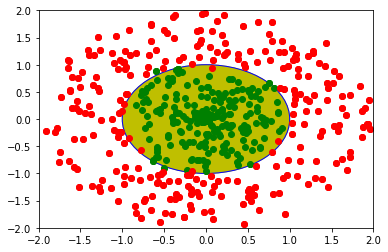

In [ ]:
print_model(model1,testx)

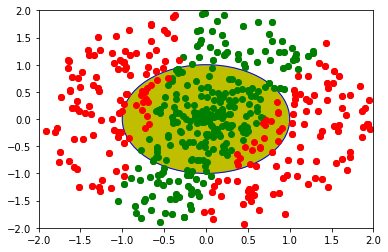

In [ ]:
print_model(model2,testx)

In [ ]:
model3 = generate_single_hidden_MLP(2) 
training_routine(model3,dataset,10000,gpu)

Using GPU
At iteration 0
Training loss : 0.81494284
Training accuracy : 0.5012
Validation loss : 0.79594237
Validation accuracy : 0.516
At iteration 100
Training loss : 0.74814236
Training accuracy : 0.5012
Validation loss : 0.7380203
Validation accuracy : 0.516
At iteration 200
Training loss : 0.71993506
Training accuracy : 0.5012
Validation loss : 0.714135
Validation accuracy : 0.516
At iteration 300
Training loss : 0.703812
Training accuracy : 0.5012
Validation loss : 0.7008543
Validation accuracy : 0.516
At iteration 400
Training loss : 0.6960314
Training accuracy : 0.5012
Validation loss : 0.6947032
Validation accuracy : 0.516
At iteration 500
Training loss : 0.6928041
Training accuracy : 0.5575
Validation loss : 0.6923409
Validation accuracy : 0.564
At iteration 600
Training loss : 0.6907184
Training accuracy : 0.6362
Validation loss : 0.6907318
Validation accuracy : 0.646
At iteration 700
Training loss : 0.6886924
Training accuracy : 0.642
Validation loss : 0.6889797
Validation 

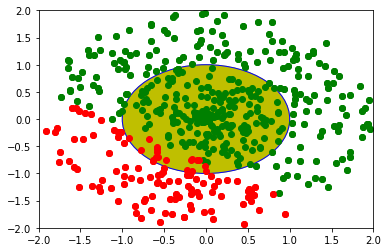

In [ ]:
print_model(model3,testx)